In [1]:
# Dataset

import numpy as np
import pandas as pd

# https://www.kaggle.com/datasets/rockinjas123/spam-ham-emails
data = pd.read_csv('emails.csv')

data

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [2]:
# Data Pre-processing

print(f"Rows Before Pre-Pocessing: {len(data.index)}")

# Duplicate Rows Dropped
data.drop_duplicates(inplace=True)

# Rows will null value are useless. So drop them.
data.dropna(axis = 'index')

print(f"Rows After Pre-Pocessing: {len(data.index)}")

Rows Before Pre-Pocessing: 5728
Rows After Pre-Pocessing: 5695


In [3]:
from sklearn.model_selection import train_test_split

x = data.text.values
y = data.spam.values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8, stratify = y)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# Counting word frequencies in order to convert word to number for calculation purpose.
xTrain_cv = cv.fit_transform(xTrain)
xTest_cv = cv.transform(xTest)



In [5]:
# Correlation


cvDf = pd.DataFrame(xTrain_cv.todense(), columns=cv.get_feature_names_out())
cvDf['spam@unique'] = yTrain
correlation = cvDf.corrwith(cvDf['spam@unique'])
correlation



00            -0.034243
000            0.105945
0000           0.120579
000000         0.026358
00000000      -0.011176
                 ...   
zzmacmac      -0.008329
zzn            0.026358
zzncacst      -0.011780
zzzz           0.042336
spam@unique    1.000000
Length: 33510, dtype: float64

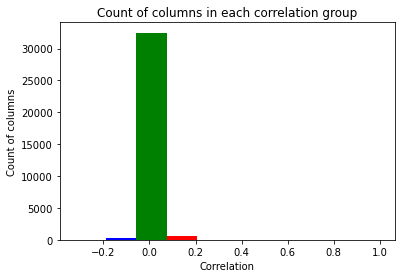

In [6]:
import matplotlib.pyplot as plt

N, bins, patches  = plt.hist(correlation)


patches[1].set_facecolor('blue')
patches[2].set_facecolor('green')
patches[3].set_facecolor('red')


plt.xlabel('Correlation')
plt.ylabel('Count of columns')
plt.title('Count of columns in each correlation group')

plt.show()

In [7]:
# Scaling

from sklearn.preprocessing import MaxAbsScaler

mas = MaxAbsScaler()
mas.fit(xTrain_cv)
xTrainScaled = mas.transform(xTrain_cv)
xTestScaled = mas.transform(xTest_cv)

# Here x variables are scaled between 0 to 1

In [8]:
def modelData(model, scaled=True):
    x = xTrainScaled if scaled else xTrain_cv
    y = yTrain
    model.fit(x,y)
    return model

In [9]:
from sklearn.metrics import precision_score, f1_score, recall_score,roc_curve, ConfusionMatrixDisplay



def display_score(trained_model, scaled = True, probability = True):
    x = xTestScaled if scaled else xTest_cv
    y = yTest
    y_pred = trained_model.predict(x)
    name = str(type(trained_model).__name__)
    
    name += "<Scaled Data>" if scaled else ""

    acc = trained_model.score(x, y)
    prec = precision_score(y, y_pred)
    f1scre = f1_score(y, y_pred)
    recal = recall_score(y, y_pred)
  
    print(f"Accuracy: {acc}\nPrecision: {prec}\nF1 Score: {f1scre}\nRecall Score: {recal}")

    fpr, tpr = None, None

    if probability:
        y_score = trained_model.predict_proba(x)
        y_score = y_score[:, 1]
        fpr, tpr, _ = roc_curve(y, y_score)
        
    print()
    mat = ConfusionMatrixDisplay.from_predictions( y, y_pred)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print()
    return {"name":name , "acc": acc, "prec":prec, "f1scre":f1scre, "recal":recal,"fpr":fpr, "tpr":tpr,"mat": mat}

In [10]:
tests = [
  "Hello Sir! I hope you are doing well. I have attached the photo of Lab-6 marking correction that you have made. I hope that you would be kind enough to look in to the matter and oblige therby.",
  "Dear students, Please do the attached short assignment by 4 May. There will be no class tomorrow. Hence, I have decided to take tomorrow's quiz online. You will have a 3-hour window from 4 PM tp 7 PM to do the quiz.",
  "Click here and get free uber promo codes"
  ]
tests_cv = cv.transform(tests)
testsScaled = mas.transform(tests_cv)

def testResults(model, scaled=True):

    results = model.predict(testsScaled if scaled else tests_cv)
    assert len(results) == len(tests), f"length of results, {len(results)} and tests, {len(tests)} are unequal"
    print("Result of the Emails:")
    for i in range(len(results)):
        spam = "spam" if results[i] == 1 else "ok"
        if len(tests[i]) > 80:
            print(f"{spam}  -->  \"{tests[i][0:35]} ... {tests[i][-35:]}\"")
        else:
            print(f"{spam}  -->  \"{tests[i]}\"")

Accuracy: 0.9938542581211589
Precision: 0.9854545454545455
F1 Score: 0.9872495446265939
Recall Score: 0.9890510948905109



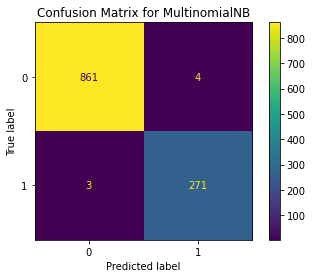


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
spam  -->  "Click here and get free uber promo codes"


In [12]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB as MNB


naive_bayes= modelData(MNB(), False)

mnb = display_score(naive_bayes, False)

testResults(naive_bayes, False)

Accuracy: 0.9868305531167691
Precision: 0.96415770609319
F1 Score: 0.9728752260397829
Recall Score: 0.9817518248175182



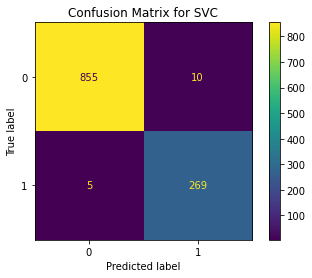


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
spam  -->  "Click here and get free uber promo codes"


In [13]:
# Support Vector Classifier

from sklearn.svm import SVC


support_vector= modelData( SVC(kernel="linear", probability=True) , False)

svc = display_score(support_vector, False, True)

testResults(support_vector, False)

Accuracy: 0.9648814749780509
Precision: 0.9957627118644068
F1 Score: 0.9215686274509803
Recall Score: 0.8576642335766423



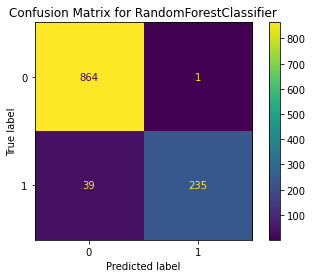


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
spam  -->  "Click here and get free uber promo codes"


In [14]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier as RFC


random_forest= modelData(RFC(n_estimators=50), False)

rfc = display_score(random_forest,False)

testResults(random_forest,False)

Accuracy: 0.9771729587357331
Precision: 0.9920634920634921
F1 Score: 0.9505703422053231
Recall Score: 0.9124087591240876



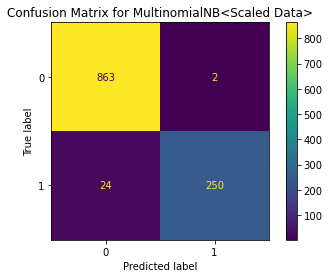


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
ok  -->  "Click here and get free uber promo codes"


In [15]:
# Multinomial Naive Bayes (For Scaled Data)

from sklearn.naive_bayes import MultinomialNB as MNB

mnb_Scaled = modelData(MNB())

mnbS = display_score(mnb_Scaled)

testResults(mnb_Scaled)

Accuracy: 0.9631255487269534
Precision: 0.953125
F1 Score: 0.9207547169811321
Recall Score: 0.8905109489051095



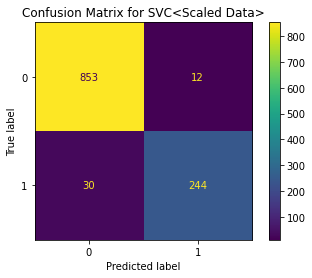


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
ok  -->  "Click here and get free uber promo codes"


In [16]:
# Support Vector Classifier (For scaled Data)

from sklearn.svm import SVC

svc_Scaled = modelData( SVC(kernel="linear", probability = True) )

svcS = display_score(svc_Scaled, probability= True )

testResults(svc_Scaled )

Accuracy: 0.961369622475856
Precision: 1.0
F1 Score: 0.9126984126984127
Recall Score: 0.8394160583941606



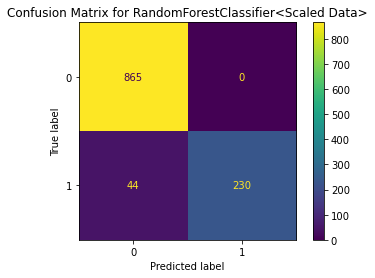


Result of the Emails:
ok  -->  "Hello Sir! I hope you are doing wel ... in to the matter and oblige therby."
ok  -->  "Dear students, Please do the attach ... w from 4 PM tp 7 PM to do the quiz."
spam  -->  "Click here and get free uber promo codes"


In [17]:
# Random Forest Classifier (For scaled Data)

from sklearn.ensemble import RandomForestClassifier as RFC

rfc_Scaled=modelData(RFC(n_estimators=50))

rfcS= display_score(rfc_Scaled)

testResults(rfc_Scaled)


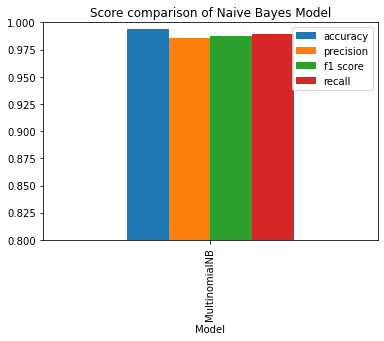

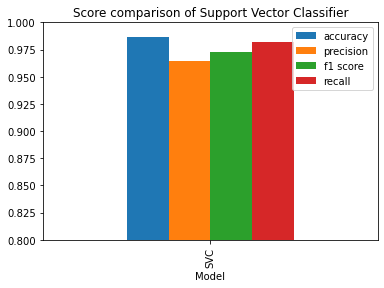

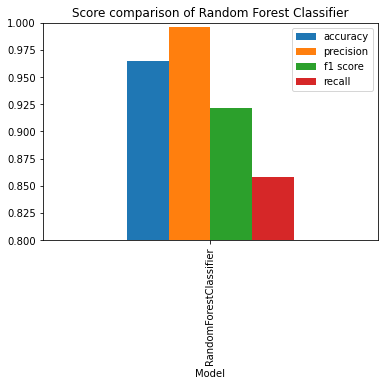

In [18]:
# Bar Chart for unscaled Data

def algoResArray(algo):
    return [ algo["name"], algo["acc"], algo["prec"], algo["f1scre"], algo["recal"] ]

def displayScore1(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Naive Bayes Model',
        ylim=(0.8,1)
      )
    
def displayScore2(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Support Vector Classifier',
        ylim=(0.8,1)
      )
    
def displayScore3(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Random Forest Classifier',
        ylim=(0.8,1)
      )

displayScore1(mnb)
displayScore2(svc)
displayScore3(rfc)

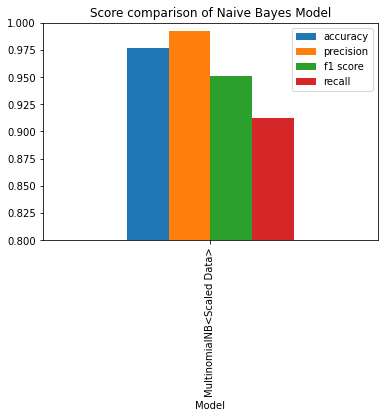

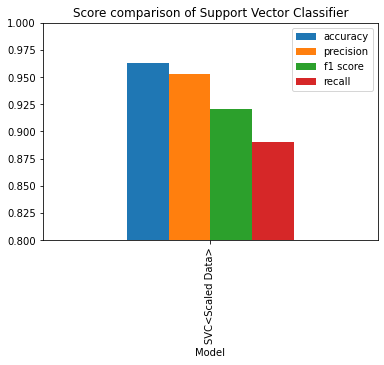

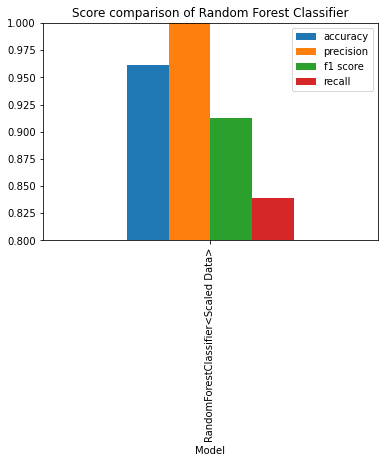

In [20]:
# Bar Chart for scaled Data

def algoResArray(algo):
    return [ algo["name"], algo["acc"], algo["prec"], algo["f1scre"], algo["recal"] ]

def displayScore1(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Naive Bayes Model',
        ylim=(0.8,1)
      )
    
def displayScore2(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Support Vector Classifier',
        ylim=(0.8,1)
      )
    
def displayScore3(temp):
    df = pd.DataFrame([
      algoResArray(temp), 
    ],

    columns=[ 'Model', "accuracy", "precision", "f1 score", "recall"])

    df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Score comparison of Random Forest Classifier',
        ylim=(0.8,1)
      )

displayScore1(mnbS)
displayScore2(svcS)
displayScore3(rfcS)

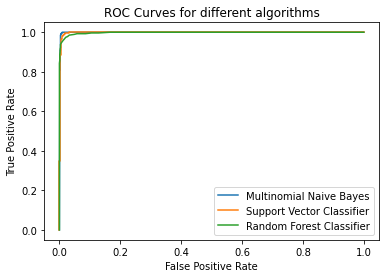

In [21]:
# Roc Curve

plt.plot(mnb["fpr"], mnb["tpr"], label= "Multinomial Naive Bayes")

plt.plot(svc["fpr"], svc["tpr"], label= "Support Vector Classifier")

plt.plot(rfc["fpr"], rfc["tpr"], label= "Random Forest Classifier")

plt.title('ROC Curves for different algorithms')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()